# Prediction with HMP 

In [1]:
import pandas as pd
from keras import Sequential
from keras import layers
from keras import regularizers
import numpy as np
from string import punctuation
import pyprind
from collections import Counter
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras import preprocessing
import os

# for reproducability
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

/home/wsun3/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def Get_score(Y_pred,Y_true):
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            print('The Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                Get_score(Y_pred[:,ii],Y_true[:,ii])
                
def read_HMP(fname):
    """Scan HMP(Histogram of Motion Patterns) features from file"""
    with open(fname) as f:
        for line in f:
            pairs=line.split()
            HMP_temp = { int(p.split(':')[0]) : float(p.split(':')[1]) for p in pairs}
    # there are 6075 bins, fill zeros
    HMP = np.zeros(6075)
    for idx in HMP_temp.keys():
        HMP[idx-1] = HMP_temp[idx]            
    return HMP

In [3]:
# load the ground truth values
label_path = '/media/win/Users/ecelab-adm/Desktop/DataSet_me18me/me18me-devset/dev-set/ground-truth/'
labels=pd.read_csv(label_path+'ground-truth_dev-set.csv')

Feat_path = '/home/wsun3/multimediaeval18/features/'
# Load video related features first
# it helps with the organization of the video names
vid = labels.video.values

Features = pd.DataFrame({'video': vid,
                   'HMP': [read_HMP(Feat_path+'HMP'+'/'+os.path.splitext(item)[0]+'.txt') for item in vid],
                       })


In [4]:
X = np.stack(Features['HMP'].values)
Y = labels[['short-term_memorability','long-term_memorability']].values

#Y = Y[:,1]
X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size=0.2, random_state=42)

In [5]:
# Load testing data
test_path = '/media/win/Users/ecelab-adm/Desktop/DataSet_me18me/test-set/features/'
test_vid = os.listdir(test_path+'HMP')
Features_test = pd.DataFrame({'video': test_vid,
                   'HMP': [read_HMP(test_path+'HMP'+'/'+item) for item in test_vid],
                       })
X_test = np.stack(Features_test['HMP'].values)

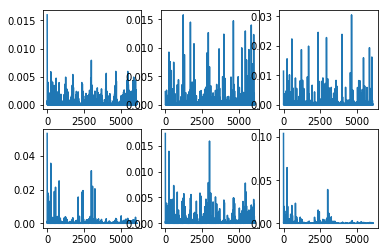

In [6]:
nrows,ncols = 2,3
N = nrows*ncols
ind = np.random.choice(8000,size=N)
for ii in range(N):
    plt.subplot(nrows,ncols,ii+1)
    plt.plot(X[ind[ii],:])
plt.show()

# Model Building

In [7]:
model = Sequential()
model.add(layers.Dense(500,activation='relu',kernel_regularizer=None,input_shape=(X.shape[1],)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(500,activation='relu',kernel_regularizer=None))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(500,activation='relu',kernel_regularizer=None))
model.add(layers.Dropout(0.1))
#model.add(layers.Dense(100,activation='relu',kernel_regularizer=regularizers.l2(0.001)))
#model.add(layers.Dropout(0.2))
model.add(layers.Dense(2,activation='sigmoid'))
model.summary()


model.compile(optimizer='rmsprop',loss=['mae'],metrics=['acc'])
history=model.fit(x=X_train,y=Y_train,batch_size=50,epochs=40,validation_split=0.2,shuffle=True,verbose=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 500)               3038000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 500)               250500    
_________________________________________________________________
dropout_3 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 1002      
Total para

# Visualizing Results

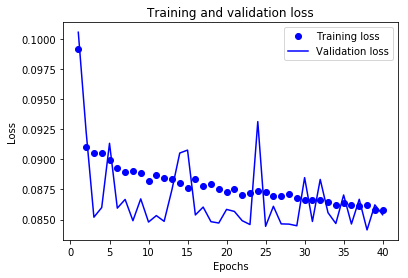

In [8]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.figure()
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


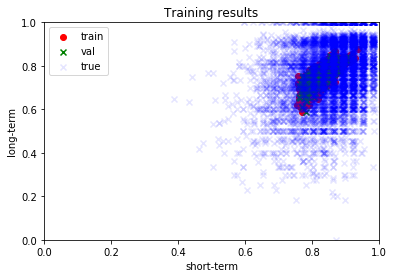

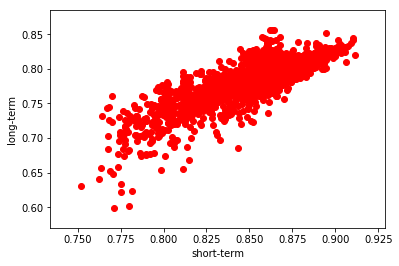

In [9]:
Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)

if len(Y.shape) == 2:
    plt.figure()
    plt.scatter(Y_pred_train[:,0],Y_pred_train[:,1],marker='o',c='r',label='train')
    plt.scatter(Y_pred_val[:,0],Y_pred_val[:,1],marker='x',c='g',label='val')
    plt.scatter(Y[:,0],Y[:,1],marker='x',c='b',label='true',alpha=0.1)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.legend()
    plt.xlabel('short-term')
    plt.ylabel('long-term')
    plt.title('Training results')
    plt.show()
    
    # plot testing results
    Y_pred = model.predict(X_test[:,:],batch_size=32)
    plt.figure()
    plt.scatter(Y_pred[:,0],Y_pred[:,1],marker='o',c='r')
    plt.xlabel('short-term')
    plt.ylabel('long-term')
    plt.show()
    
else:
    plt.figure()
    plt.scatter(Y_pred_train,Y_train,marker='o',c='r',label='train')
    plt.scatter(Y_pred_val,Y_val,marker='x',c='g',label='val')
    #plt.scatter(Y[:,0],Y[:,1],marker='x',c='b',label='true',alpha=0.1)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.legend()
    plt.xlabel('true')
    plt.ylabel('pred')
    plt.title('Training results [short-term]')
    plt.show()

In [10]:
Get_score(Y_pred_val,Y_val)

The Spearman's correlation coefficient is: 0.290
The Spearman's correlation coefficient is: 0.128
